## Setup

In [1]:
!pip install tensorflow==2.7.0

     |████████████████████████████████| 207.1 MB 7.0 MB/s eta 0:00:013    |████████████████████            | 129.2 MB 2.3 MB/s eta 0:00:35
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 6.0 MB 2.7 MB/s eta 0:00:01
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 1.6 MB 13.7 MB/s eta 0:00:01
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
     |████████████████████████████████| 25.0 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 4.6 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-macosx_10_9_x86_64.whl (3.5 MB)
     |████████████████████████████████| 93 kB 2.3 MB/s eta 0:00:011
  Usi

Install TensorFlow Quantum:

In [2]:
!pip install tensorflow-quantum

     |████████████████████████████████| 8.4 MB 2.3 MB/s eta 0:00:01
  Using cached google_api_core-1.21.0-py2.py3-none-any.whl (90 kB)
  Using cached sympy-1.8-py3-none-any.whl (6.1 MB)
  Using cached cirq_google-1.1.0-py3-none-any.whl (577 kB)
  Using cached google_auth-1.18.0-py2.py3-none-any.whl (90 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
     |████████████████████████████████| 1.6 MB 2.9 MB/s eta 0:00:01
  Using cached protobuf-3.17.3-cp38-cp38-macosx_10_9_x86_64.whl (1.0 MB)
  Using cached proto_plus-1.22.2-py3-none-any.whl (47 kB)
ERROR: proto-plus 1.22.2 has requirement protobuf<5.0.0dev,>=3.19.0, but you'll have protobuf 3.17.3 which is incompatible.
ERROR: google-cloud-language 2.0.0 has requirement google-api-core[grpc]<2.0.0dev,>=1.22.2, but you'll have google-api-core 1.21.0 which is incompatible.
ERROR: cirq-google 1.1.0 has requirement cirq-core==1.1.0, but you'll have cirq-core 0.13.1 which is incompatible.
  Attempting uninstall:

In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/Users/nadinemeister/opt/anaconda3/envs/qtf_py3.6/lib/python3.6/site-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Encodings

### 1.1 Data Import/Rescaling

In [4]:
import pandas as pd
import numpy as np

test_df = pd.read_csv('sample_data/mock_test_set.csv')
train_df = pd.read_csv('sample_data/mock_train_set.csv')

# take logs on columns 1 and 2
test_df_proc = test_df.copy()
test_df_proc[['1','2']] = np.log10(test_df_proc[['1','2']])
train_df_proc = train_df.copy()
train_df_proc[['1','2']] = np.log10(train_df_proc[['1','2']])

# "soft-normalization" - divide each column by mean (so that the first column doesnt take up all the weight)
for lbl in range(4):
  test_df_proc[str(lbl)] /= test_df_proc[str(lbl)].mean()
  train_df_proc[str(lbl)] /= train_df_proc[str(lbl)].mean()

#split into x/y
x_test = test_df_proc[['0','1','2','3']]
y_test = test_df_proc['4']
x_train = train_df_proc[['0','1','2','3']]
y_train = train_df_proc['4']

# Convert output data from {0,1} to {[1,0], [0,1]} for CategoricalCrossEntropy 
new_y_test = np.array([[1,0] if ele == 0 else [0,1] for ele in y_test])
new_y_train = np.array([[1,0] if ele == 0 else [0,1] for ele in y_train])

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/mock_test_set.csv'

### 1.2 Amplitude Encoding

In [ ]:
# amplitude encoding function
def convert_to_circuit_ampl(input_row):
  qubits = cirq.LineQubit.range(2)
  circuit = cirq.Circuit()
  # 0 -> 00, 1-> 01, 2-> 10, 3->11
  input_row /= np.sqrt(sum(x**2 for x in input_row))

  # calculate y angles
  #   first one divides amplitude between 00+01 and 10+11
  #   second one divides between 00 and 01, and third one for 10 and 11
  th = 2* np.arccos(np.sqrt(input_row[0]**2 + input_row[1]**2)) 
  ph1 = 2* np.arccos(input_row[0]/np.sqrt(input_row[0]**2 + input_row[1]**2))
  ph2 = 2* np.arccos(input_row[2]/np.sqrt(input_row[2]**2 + input_row[3]**2))

  circuit.append(cirq.ry(th).on(qubits[0]))
  circuit.append(cirq.ry(ph1).controlled(1, control_values=[0]).on(qubits[0], qubits[1]))
  circuit.append(cirq.ry(ph2).controlled(1, control_values=[1]).on(qubits[0], qubits[1]))

  return circuit

x_train_circ_amp = [convert_to_circuit_ampl(x[1]) for x in x_train.iterrows()]
x_test_circ_amp = [convert_to_circuit_ampl(x[1]) for x in x_test.iterrows()]

x_train_tfcirc_amp = tfq.convert_to_tensor(x_train_circ_amp)
x_test_tfcirc_amp = tfq.convert_to_tensor(x_test_circ_amp)

### 1.3 Angle Encoding

In [12]:
# angle encoding function
def convert_to_circuit_ang(row):
    """Encode a vector with features in [0, 3] using angle-encoding"""
    values = (np.array(row).astype(np.float32)) / 3
    values = values * (2 * np.pi) - np.pi
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit(cirq.rx(v)(q) for v,q in zip(values, qubits))
    print(type(circuit))
    return circuit

convert_to_circuit_ang([0,0,0,0,0,0,0,1])

# x_train_circ_ang = [convert_to_circuit_ang(x[1]) for x in x_train.iterrows()]
# x_test_circ_ang = [convert_to_circuit_ang(x[1]) for x in x_test.iterrows()]

# x_train_tfcirc_ang = tfq.convert_to_tensor(x_train_circ_ang)
# x_test_tfcirc_ang = tfq.convert_to_tensor(x_test_circ_ang)

<class 'cirq.circuits.circuit.Circuit'>


(0, 0): ───Rx(-π)────────

(0, 1): ───Rx(-π)────────

(0, 2): ───Rx(-π)────────

(0, 3): ───Rx(-π)────────

(0, 4): ───Rx(-π)────────

(0, 5): ───Rx(-π)────────

(0, 6): ───Rx(-π)────────

(0, 7): ───Rx(-0.333π)───

# 2. Creating the Variational Circuit

In [13]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits):
        self.data_qubits = data_qubits

    # Applies the two qubit gate 'gate' on each pair of qubits in the circuit
    # The parameter is the 'symbol' exponent of the gate
    def add_multi_qubit_layer(self, circuit, gate, prefix):
        for i, qubit1 in enumerate(self.data_qubits):
            for j, qubit2 in enumerate(self.data_qubits):
                if not i == j:
                    symbol = sympy.Symbol(prefix + '-' + str(i) + "->" + str(j))
                    circuit.append(gate(qubit1, qubit2)**symbol)
    
    # Applies the single qubit gate 'gate' on each qubit in the circuit
    # The parameter is the 'symbol' exponent of the gate
    def add_single_qubit_rotation_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '_' + str(i))
            circuit.append(gate(symbol)(qubit))

In [9]:
def build_q_circuit_model(num_qubits):
  # Create the parameterized circuit.
  qubits = cirq.LineQubit.range(num_qubits)

  circuit = cirq.Circuit()
  builder = CircuitLayerBuilder(data_qubits = qubits)

    # Then add layers (experiment by adding more).
  builder.add_single_qubit_rotation_layer(circuit, cirq.rx, "rx1")
  builder.add_single_qubit_rotation_layer(circuit, cirq.ry, "ry1")
  builder.add_single_qubit_rotation_layer(circuit, cirq.rz, "rz1")
  builder.add_multi_qubit_layer(circuit, cirq.CNOT, "cnot1")
  builder.add_single_qubit_rotation_layer(circuit, cirq.rx, "rx2")
  builder.add_single_qubit_rotation_layer(circuit, cirq.ry, "ry2")
  builder.add_single_qubit_rotation_layer(circuit, cirq.rz, "rz2")
  builder.add_multi_qubit_layer(circuit, cirq.CNOT, "cnot2")
  builder.add_single_qubit_rotation_layer(circuit, cirq.rx, "rx3")
  builder.add_single_qubit_rotation_layer(circuit, cirq.ry, "ry3")
  builder.add_single_qubit_rotation_layer(circuit, cirq.rz, "rz3")

  q_data_input = tf.keras.Input(
      shape=(), dtype=tf.dtypes.string)
  expectation = tfq.layers.PQC(circuit, cirq.Z(qubits[-1]))
  expectation_output = expectation(q_data_input)

  # Attach the classical SoftMax classifier
  classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
  classifier_output = classifier(expectation_output)
  model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

  # Standard compilation for classification
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy())
  tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

  return model

q_model_amp = build_q_circuit_model(2)
q_model_ang = build_q_circuit_model(4)

# 3. Train the models and view results

## 3.1 Amplitude Encoding

In [10]:
history_amp = q_model_amp.fit(x=x_train_tfcirc_amp, 
                    y=new_y_train, 
                    epochs=10, 
                    verbose=1,
                    validation_data=(x_test_tfcirc_amp, new_y_test))

Epoch 1/10
10/10 [==============================] - 3s 124ms/step - loss: 0.5661 - val_loss: 0.3011
Epoch 2/10
10/10 [==============================] - 1s 71ms/step - loss: 0.4580 - val_loss: 0.2252
Epoch 3/10
10/10 [==============================] - 1s 109ms/step - loss: 0.4178 - val_loss: 0.1861
Epoch 4/10
10/10 [==============================] - 1s 84ms/step - loss: 0.4160 - val_loss: 0.2000
Epoch 5/10
10/10 [==============================] - 1s 82ms/step - loss: 0.4014 - val_loss: 0.1999
Epoch 6/10
10/10 [==============================] - 1s 68ms/step - loss: 0.4212 - val_loss: 0.2207
Epoch 7/10
10/10 [==============================] - 1s 97ms/step - loss: 0.4292 - val_loss: 0.2253
Epoch 8/10
10/10 [==============================] - 1s 98ms/step - loss: 0.4530 - val_loss: 0.2111
Epoch 9/10
10/10 [==============================] - 1s 73ms/step - loss: 0.4011 - val_loss: 0.2223
Epoch 10/10
10/10 [==============================] - 1s 76ms/step - loss: 0.3786 - val_loss: 0.1729


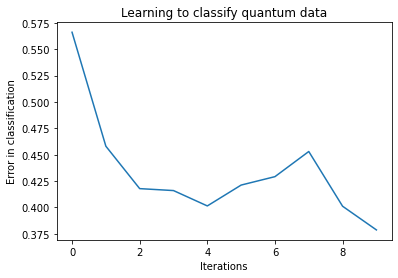

Final loss value:
0.3786287009716034


In [11]:
plt.plot(history_amp.history['loss'])
plt.title("Learning to classify quantum data")
plt.xlabel("Iterations")
plt.ylabel("Error in classification")
plt.show()
print("Final loss value:")
print(history_amp.history["loss"][-1])

### 3.1.1 Prediction accuracy of Amplitude encoding model

In [15]:
res = q_model_amp.predict(x_test_tfcirc_amp)
res_pp = [0 if li[0] > li[1] else 1 for li in res]

np.sum(y_test == res_pp) / len(y_test)

0.9666666666666667

## 3.2 Angle Encoding

In [19]:
# angle
history_ang = q_model_ang.fit(x=x_train_tfcirc_ang, 
                    y=new_y_train, 
                    epochs=10, 
                    verbose=1,
                    validation_data=(x_test_tfcirc_ang, new_y_test))

Epoch 1/10
10/10 [==============================] - 4s 288ms/step - loss: 0.7005 - val_loss: 0.6926
Epoch 2/10
10/10 [==============================] - 2s 235ms/step - loss: 0.6930 - val_loss: 0.7058
Epoch 3/10
10/10 [==============================] - 2s 198ms/step - loss: 0.6959 - val_loss: 0.6992
Epoch 4/10
10/10 [==============================] - 2s 187ms/step - loss: 0.6941 - val_loss: 0.6969
Epoch 5/10
10/10 [==============================] - 2s 184ms/step - loss: 0.6930 - val_loss: 0.6949
Epoch 6/10
10/10 [==============================] - 2s 169ms/step - loss: 0.6924 - val_loss: 0.6944
Epoch 7/10
10/10 [==============================] - 2s 166ms/step - loss: 0.6938 - val_loss: 0.6964
Epoch 8/10
10/10 [==============================] - 2s 154ms/step - loss: 0.6937 - val_loss: 0.6966
Epoch 9/10
10/10 [==============================] - 2s 172ms/step - loss: 0.6925 - val_loss: 0.6942
Epoch 10/10
10/10 [==============================] - 2s 170ms/step - loss: 0.6961 - val_loss: 0.6932

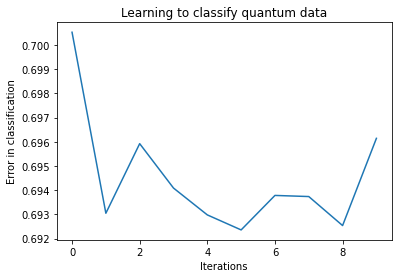

Final loss value:
0.6961425542831421


In [20]:
plt.plot(history_ang.history['loss'])
plt.title("Learning to classify quantum data")
plt.xlabel("Iterations")
plt.ylabel("Error in classification")
plt.show()
print("Final loss value:")
print(history_ang.history["loss"][-1])

### 3.2.1 Prediction Accuracy of Angle Encoding model

In [21]:
res = q_model_ang.predict(x_test_tfcirc_ang)
res_pp = [0 if li[0] > li[1] else 1 for li in res]

np.sum(y_test == res_pp) / len(y_test)

0.48333333333333334